In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, check_datetime_sanity, check_singularity_of_values
from utils.plotting import *
from src.src import *

In [4]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name="merged_data_dict.pkl", file_path=WORK_DATA_DIR)

df_w = df_all.copy()

# Select data

In [5]:
## SELECT COLS INCLUDED HERE
# # len daily returns
drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"] + data_dict["data"]["df_cols"]["aaii_bull"] + data_dict["data"]["df_cols"]["cbeo_vix"] + data_dict["data"]["df_cols"]["termspread"]

# # len 1500
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"]

# # len 760
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"]

# # len 660
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"]

# # len 440
# drop_cols = data_dict["data"]["df_cols"]["fears"]

# # len 270
# drop_cols = None

In [6]:
## DROP COLS
if drop_cols != None:
    df_w = df_w.drop(drop_cols, axis=1).copy()

# keep actual sp500 prices
data_dict["data"].update(sp_true_vals="sp_true_vals")

## preserve actual prices
df_w[data_dict["data"]["sp_true_vals"]] = df_w["sp_close"]

In [10]:
# edit data_dict

# all sp cols, lags & leads
data_dict["data"].update(sp_cols=[item for item in df_w.columns if "sp_close" in item])


relevant_cols=[
    # 'fears35',
    # 'fears25',
    # 'fears30',
    # 'vixo',
    # 'naaim_ind',
    # 'naaim_max',
    # 'naaim_q1',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    # 'termspread',
    # 'pc_ratio',
    # 'aaii_Bullish',
    # 'aaii_Bearish',
    # 'aaii_Neutral',
    # 'goog_sent'
] 

# relevant cols are features + sp_cols + target col, thus all relevant columns
relevant_cols = relevant_cols + data_dict["data"]["sp_cols"]

data_dict["data"].update(relevant_cols=relevant_cols)

In [11]:
# sanity check
_ = [item for item in data_dict["data"]["relevant_cols"] if item not in df_w.columns]
assert len(_) == 0, f"Relevant cols has columns not pertaining to df: {_}"

In [12]:
# datetime sanity
check_datetime_sanity(df_w.date)
check_singularity_of_values(df_w.date)

# Transform

In [13]:
log_trans = ["vixo", 'aaii_Bullish', 'aaii_Bearish', 'aaii_Neutral', 'termspread']
log_trans2 = ['termspread']
log_returns = [] + data_dict["data"]["sp_cols"]

log_trans = [item for item in log_trans if item in df_w.columns]
log_trans2 = [item for item in log_trans2 if item in df_w.columns]
log_returns = [item for item in log_returns if item in df_w.columns]

df_w, t_dist, t_log = df_transform(df_w,
                               cols=log_trans,
                               func=arr_log_transform)
df_w, t_dist2, t_log2 = df_transform(df_w,
                               cols=log_trans2,
                               func=arr_log_transform)

df_w, r_dist, r_log = df_transform(df_w,
                               cols=log_returns,
                               func=arr_log_return)

In [14]:
t_dist.update(r_dist)

data_dict["data_transformation"].update(dist_translation=t_dist)
data_dict["data_transformation"].update(log_transformation=t_log)
data_dict["data_transformation"].update(log_transformation2=t_log2)
data_dict["data_transformation"].update(log_returns=r_log)

data_dict["data_transformation"]["log_returns"]

{'sp_close': True,
 'sp_close_lead4': True,
 'sp_close_lead3': True,
 'sp_close_lead2': True,
 'sp_close_lead1': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_close_lag4': True,
 'sp_close_lag5': True,
 'sp_close_lag6': True,
 'sp_close_lag7': True,
 'sp_close_lag8': True,
 'sp_close_lag9': True,
 'sp_close_lag10': True}

# select weekly data

In [15]:
# ## CUT TO WEEKLY DATA POST LOG
# df_w = cut_to_weekly_data(df_w, "is_thu").reset_index(drop=True)

# Stats Test

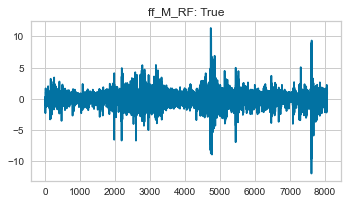

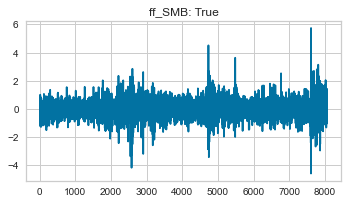

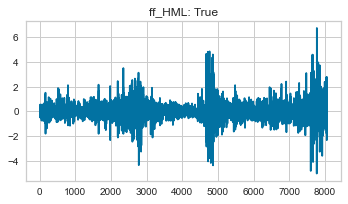

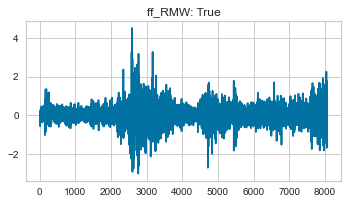

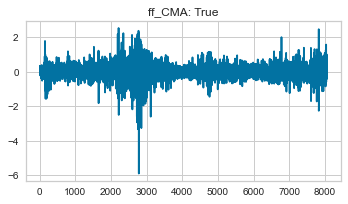

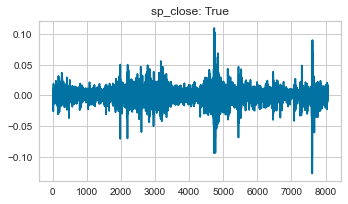

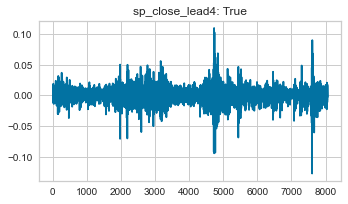

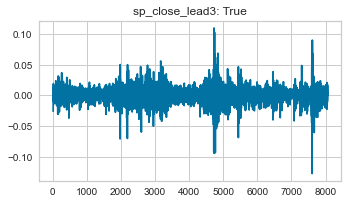

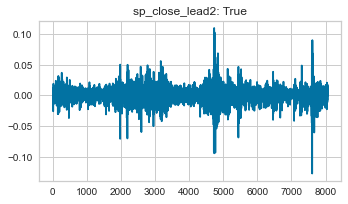

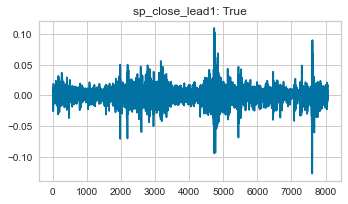

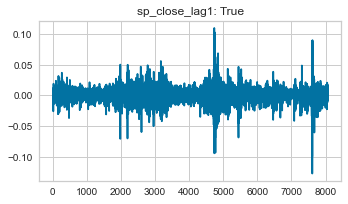

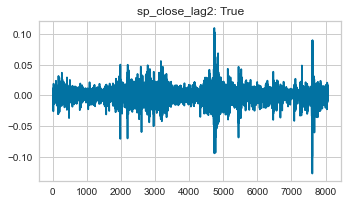

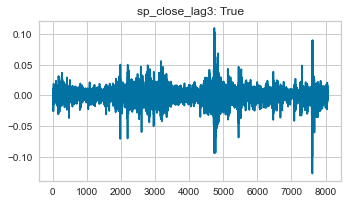

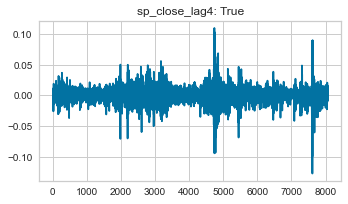

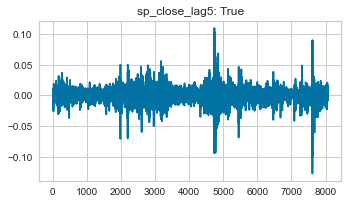

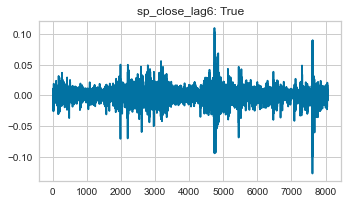

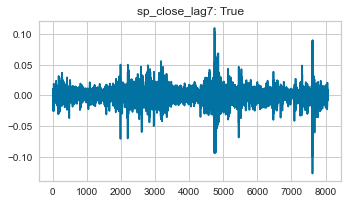

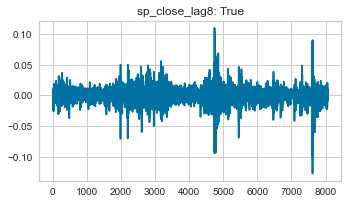

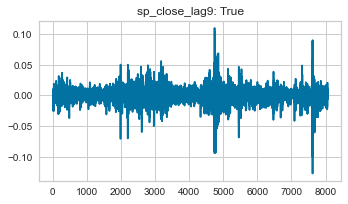

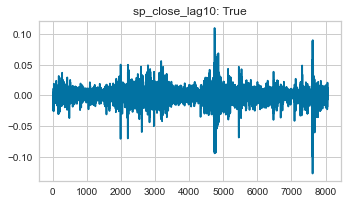

{'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'sp_close': True,
 'sp_close_lead4': True,
 'sp_close_lead3': True,
 'sp_close_lead2': True,
 'sp_close_lead1': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_close_lag4': True,
 'sp_close_lag5': True,
 'sp_close_lag6': True,
 'sp_close_lag7': True,
 'sp_close_lag8': True,
 'sp_close_lag9': True,
 'sp_close_lag10': True}

In [16]:
# test normality & stationarity
stest = StatsTest(plot=True)

stationarity = stest.df_test_stationarity(df_w, data_dict["data"]["relevant_cols"])
data_dict["data_stests"].update(stationarity=stationarity)

stationarity

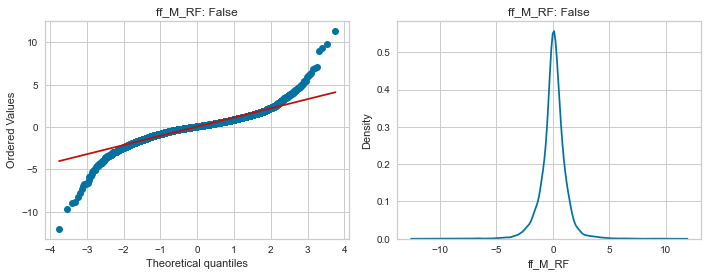

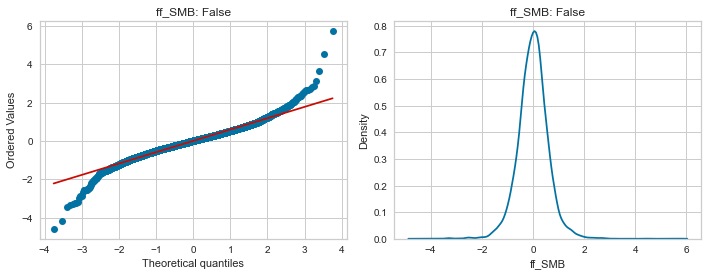

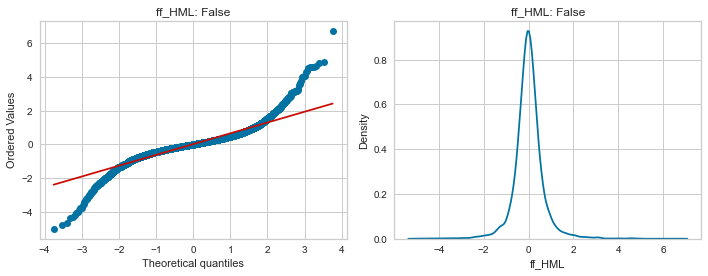

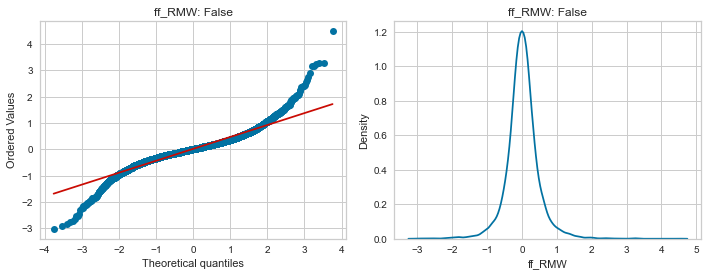

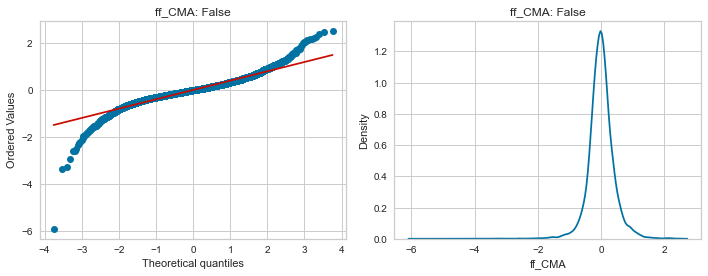

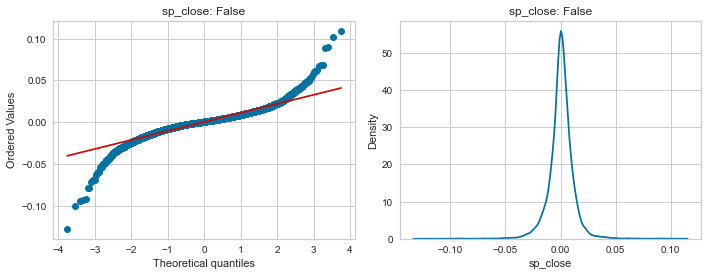

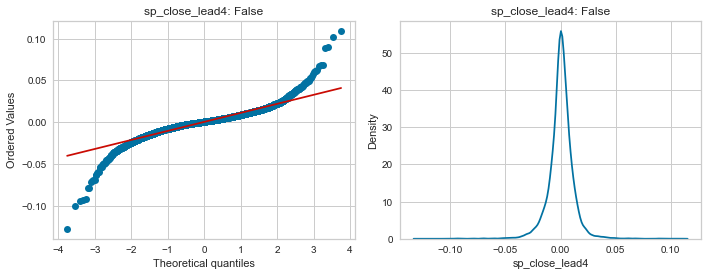

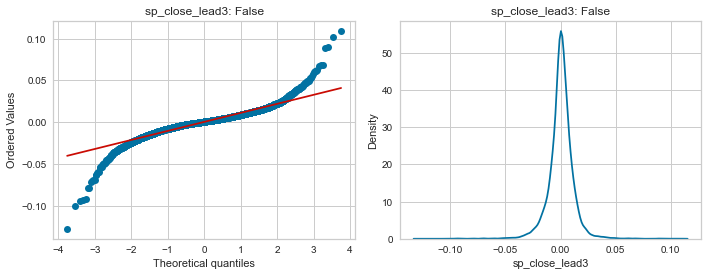

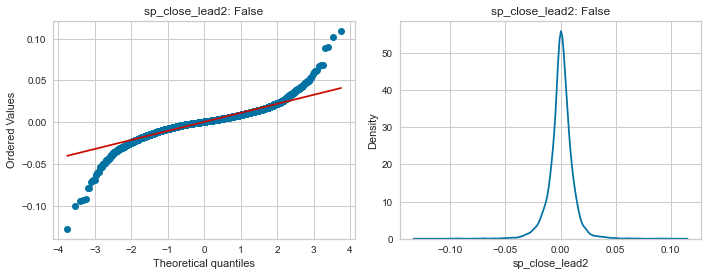

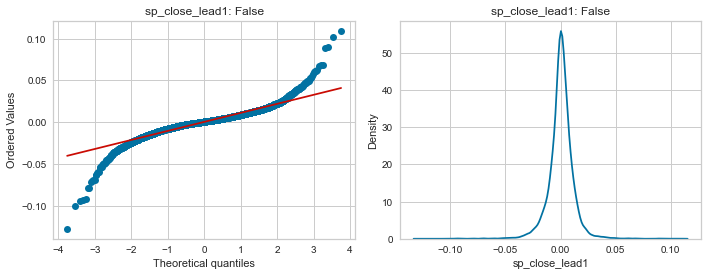

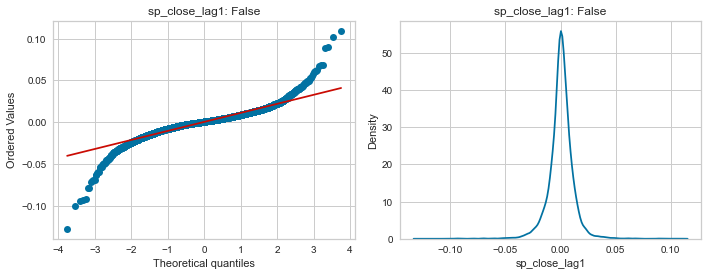

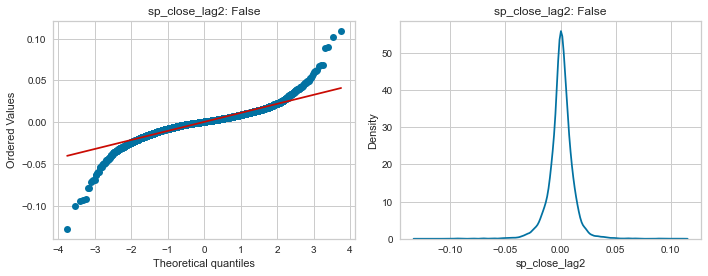

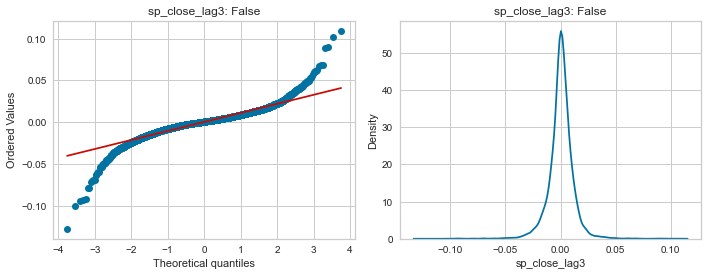

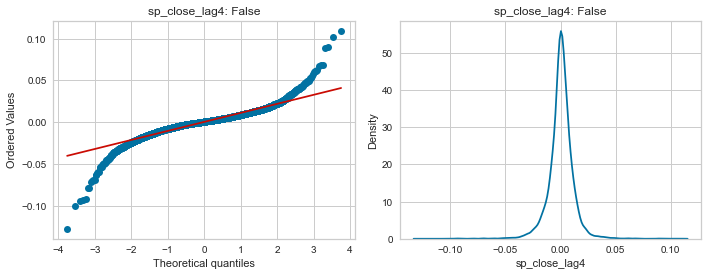

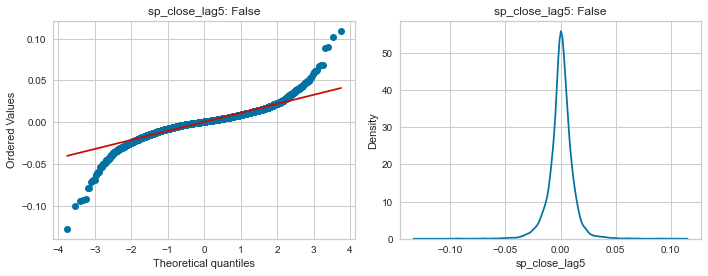

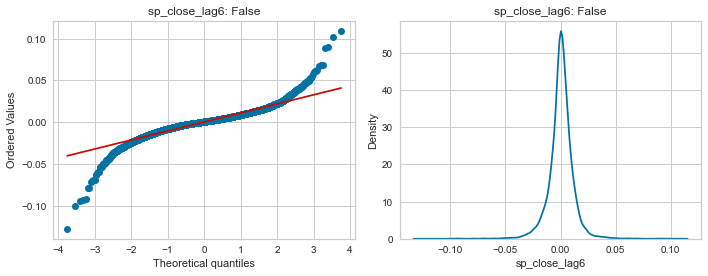

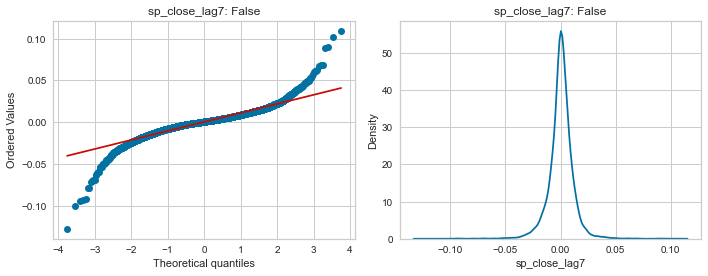

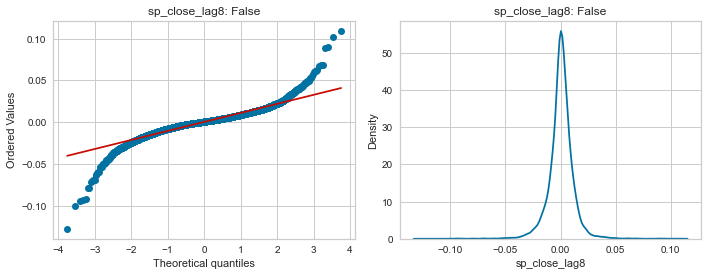

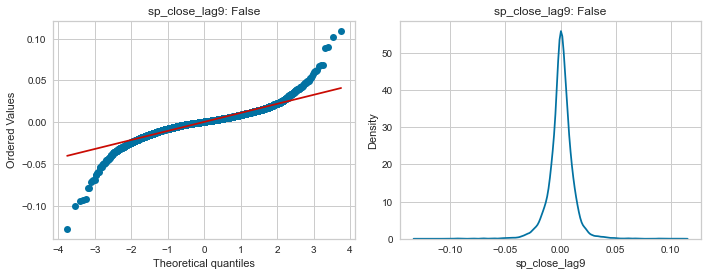

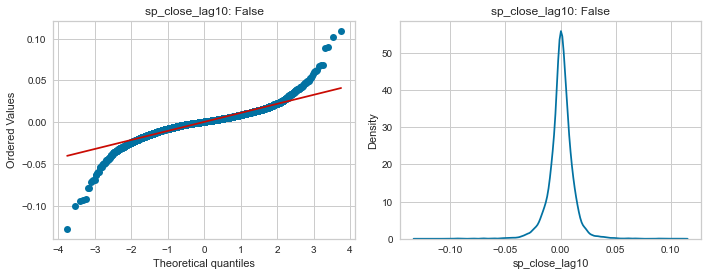

{'ff_M_RF': False,
 'ff_SMB': False,
 'ff_HML': False,
 'ff_RMW': False,
 'ff_CMA': False,
 'sp_close': False,
 'sp_close_lead4': False,
 'sp_close_lead3': False,
 'sp_close_lead2': False,
 'sp_close_lead1': False,
 'sp_close_lag1': False,
 'sp_close_lag2': False,
 'sp_close_lag3': False,
 'sp_close_lag4': False,
 'sp_close_lag5': False,
 'sp_close_lag6': False,
 'sp_close_lag7': False,
 'sp_close_lag8': False,
 'sp_close_lag9': False,
 'sp_close_lag10': False}

In [17]:
normality = stest.df_test_normality(df_w, cols=data_dict["data"]["relevant_cols"])
data_dict["data_stests"].update(normality=normality)
normality

# Feature Eng

In [18]:
df_w["weekday"] = is_day(df_w.date)

In [19]:
df_w = pd.concat([df_w,
                  pd.get_dummies(df_w.weekday).add_prefix("weekday_")],
                 axis=1)

# Saving

In [20]:
if drop_cols == ['fears25', 'fears30', 'fears35', 'goog_sent']:
    print("Saving as df_weekly_660")
    save_file(df_w, file_name="df_weekly_660.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_660.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == None:
    print("Saving as df_weekly_270")
    save_file(df_w, file_name="df_weekly_270.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_270.pkl", file_path=WORK_DATA_DIR, index=False)

elif drop_cols == data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"]:
    print("Saving as df_weekly_760")
    save_file(df_w, file_name="df_weekly_760.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_760.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == ['fears25', 'fears30', 'fears35']:
    print("Saving as df_weekly_440")
    save_file(df_w, file_name="df_weekly_440.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_440.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == ['fears25',
                 'fears30',
                 'fears35',
                 'goog_sent',
                 'Call',
                 'Put',
                 'Total',
                 'pc_ratio',
                 'Mean/Average',
                 'naaim_max',
                 'naaim_q1',
                 'Quart 2 (median)',
                 'Quart 3 (25% at/above)',
                 'Most Bullish Response',
                 'naaim_std',
                 'naaim_ind',
                 'S&P 500']:
    print("Saving as df_weekly_1560")
    save_file(df_w, file_name="df_weekly_1560.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_1560.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"]:
    print("Saving as df_weekly_1560")
    save_file(df_w, file_name="df_weekly_1560.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_weekly_1560.pkl", file_path=WORK_DATA_DIR, index=False)
    
elif drop_cols == data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"] + data_dict["data"]["df_cols"]["aaii_bull"] + data_dict["data"]["df_cols"]["cbeo_vix"] + data_dict["data"]["df_cols"]["termspread"]:
    print("Saving as df_daily_8055")
    save_file(df_w, file_name="df_daily_8055.csv", file_path=WORK_DATA_DIR, index=False)
    save_file(data_dict, file_name="dict_daily_8055.pkl", file_path=WORK_DATA_DIR, index=False)

Saving as df_daily_8055
